In [251]:
# Read raw data from the file
import numpy as np
import pandas as pd            
import string
import math
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

dataset = pd.read_csv('Texas Last Statement - CSV.csv' , encoding="cp1252")


In [120]:
# Creating a new dataframe only for LastStatements
last = pd.Series(dataset['LastStatement'])
last_words = pd.DataFrame({'LastStatement': last})

In [116]:
# Importing required NLTK libraries for further usage
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

exclude = set(string.punctuation) ## stores all the punctuations
lemma = WordNetLemmatizer() # used for lemmatization
stop = set(stopwords.words('english'))- {'no','not','donot',"don't",'very',"aren't"}

#!pip install -U spacy
import spacy

#!python -m spacy download en_core_web_md
nlp_md = spacy.load('en_core_web_md')

## Cleaning Statements

In [121]:
def clean(doc):
    doc = ''.join(ch for ch in doc if ch not in exclude)
    doc = nlp_md(doc)   #Normalizing using spacy
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    stop_free = [tok for tok in tokens if tok not in stop]
    normalized = ' '.join(stop_free)
    without_digits = " ".join([x for x in normalized.split() if not (x.isdigit() 
                                          or x[0] == '-' and x[1:].isdigit())])
    return without_digits

cleaned_last_statement = {}

for s_id in range(last_words.shape[0]):
    last_words.loc[s_id]['LastStatement'] = clean(last_words.loc[s_id]['LastStatement'])
    cleaned_last_statement[s_id] = last_words.loc[s_id]['LastStatement']


In [130]:
# import pickle
# with open('/Users/biksingh/Natural_Language_Generation/epiphron/data/corpusDocDict.pickle', 'rb') as handle:
#     corpusDocDict = pickle.load(handle)

## Creating Bag of words for each statement and also calculating total number of words in each statement

In [310]:
bag_of_words = {}
statement_word_count = {}
for s_id in range(len(last_words)):
    words_list = last_words.iloc[s_id]['LastStatement'].split()
    statement_word_count[s_id] = len(words_list)
    bag_of_words[s_id] = {}
    for word in words_list:
        if word in bag_of_words[s_id]:
            bag_of_words[s_id][word] = bag_of_words[s_id][word] +1
        else:
            bag_of_words[s_id][word] = 1
            

In [311]:
for s_id in bag_of_words:
    sorted_x = dict(sorted(bag_of_words[s_id].items(), key=lambda kv: kv[1], reverse=True))
    bag_of_words[s_id] = sorted_x
    

## Calculating TF across all the statements

In [312]:
statementFreqDict = {}

for s_id in bag_of_words:
    for word in bag_of_words[s_id]:
        if word in statementFreqDict:
            statementFreqDict[word] = statementFreqDict[word] + bag_of_words[s_id][word]
        else:
            statementFreqDict[word] = bag_of_words[s_id][word]
        
sorted_x = dict(sorted(statementFreqDict.items(), key=lambda kv: kv[1], reverse=True))
statementFreqDict = sorted_x



## Calculating TFIDF

In [268]:
def tf(ngram, doc_id, ngram_count, ngramDocDict):
    return ngramDocDict[doc_id][ngram] / ngram_count[doc_id]

def n_containing(ngram, ngramDocDict):
    return sum(1 for doc_id in ngramDocDict if ngram in ngramDocDict[doc_id])

def idf(ngram, ngramDocDict):
    return math.log(len(ngramDocDict) / (n_containing(ngram, ngramDocDict)))

def tfidf(ngram, doc_id, ngram_count, ngramDocDict):
    return tf(ngram, doc_id, ngram_count, ngramDocDict) * idf(ngram, ngramDocDict)

In [269]:
def cal_tfidf_doc(ngramDocDict):
    
    ngram_statement_tfidf = {}
    for s_id in ngramDocDict:
        ngram_statement_tfidf[s_id] = {}

        for ngram in ngramDocDict[s_id]:
            ngram_statement_tfidf[s_id][ngram] = tfidf(ngram, s_id, statement_word_count, ngramDocDict)
            
    return ngram_statement_tfidf

In [314]:
statement_tfidf = cal_tfidf_doc(bag_of_words)

In [273]:
from heapq import heappush, heappop

heap = []

for s_id in statement_tfidf:
    for word in statement_tfidf[s_id]:
        heappush(heap, (statement_tfidf[s_id][word], word))
        
        if len(heap) > 10:
            heappop(heap)

In [274]:
while(heap):
    r = heappop(heap)
    print(r[1], r[0])

aviation 1.5165270225259369
direct 1.5165270225259369
islam 1.6558319338118794
peace 1.8034282130624324
bye 1.9933332742119558
santajaib 2.0220360300345823
singh 2.0220360300345823
goodbye 2.847232265235547
release 2.971113451779765
israel 3.0330540450518737


## Google Word2Vec embedding

In [275]:
#loading Google_news model
from gensim.models import KeyedVectors
filename = '/Users/biksingh/Natural_Language_Generation/Sprint5_Integrate_ngram_to_embedding/GoogleNews-vectors-negative300.bin'
google_model = KeyedVectors.load_word2vec_format(filename, binary=True)
vocab = google_model.vocab.keys()

In [316]:
google_embedding_avg = {} #dictionary to store words and their corresponding vectors
google_embedding_tfidf = {}
word_vect_list = [] # list storing only vectors of the words
word_not_vocab = [] # list storing words which are nt in the Google news vocab

for s_id in cleaned_last_statement:
    words_list = cleaned_last_statement[s_id].split()
    vec = 0
    count = 0
    vec_tfidf = 0
    tfidf_total = 0
    for word in words_list:
        if word in vocab:
            vec = vec + google_model[word]
            vec_tfidf += google_model[word] * statement_tfidf[s_id][word]
            tfidf_total += statement_tfidf[s_id][word]
            count += 1
        else:
            word_not_vocab.append(word)
    google_embedding_avg[s_id] = vec/count
    google_embedding_tfidf[s_id] = vec_tfidf/tfidf_total

In [ ]:
with open('/Users/biksingh/Natural_Language_Generation/Meetup_last_words/glove_embedding_avg.pickle', 'wb') as handle:
    pickle.dump(google_embedding_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/Users/biksingh/Natural_Language_Generation/Meetup_last_words/glove_embedding_tfidf.pickle', 'wb') as handle:
    pickle.dump(google_embedding_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Glove Embedding

In [320]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
filename = '/Users/biksingh/Natural_Language_Generation/Sprint5_Integrate_ngram_to_embedding/glove.6B.300d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

glove_vocab = glove_model.vocab.keys()

In [321]:
glove_embedding_avg = {} #dictionary to store words and their corresponding vectors
glove_embedding_tfidf = {}
word_not_vocab_glove = [] # list storing words which are nt in the Google news vocab


for s_id in cleaned_last_statement:
    words_list = cleaned_last_statement[s_id].split()
    vec = 0
    count = 0
    vec_tfidf = 0
    tfidf_total = 0
    for word in words_list:
        if word in glove_vocab:
            vec = vec + glove_model[word]
            vec_tfidf += glove_model[word] * statement_tfidf[s_id][word]
            tfidf_total += statement_tfidf[s_id][word]
            count += 1
        else:
            word_not_vocab_glove.append(word)
    glove_embedding_avg[s_id] = vec/count
    glove_embedding_tfidf[s_id] = vec_tfidf/tfidf_total

In [ ]:
with open('/Users/biksingh/Natural_Language_Generation/Meetup_last_words/glove_embedding_avg.pickle', 'wb') as handle:
    pickle.dump(glove_embedding_avg, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('/Users/biksingh/Natural_Language_Generation/Meetup_last_words/glove_embedding_tfidf.pickle', 'wb') as handle:
    pickle.dump(glove_embedding_tfidf, handle, protocol=pickle.HIGHEST_PROTOCOL)

## FastText Embedding


In [326]:
import fastText
fasttext_model = fastText.load_model('/Users/biksingh/Natural_Language_Generation/Sprint6_rare_in_clusters/crawl-300d-2M-subword.bin')


In [328]:
fasttext_embedding = {}
for s_id in cleaned_last_statement: 
    fasttext_embedding[s_id] = model.get_sentence_vector(cleaned_last_statement[s_id])

In [ ]:
with open('/Users/biksingh/Natural_Language_Generation/Meetup_last_words/fasttext_embedding.pickle', 'wb') as handle:
    pickle.dump(fasttext_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Spacy Embedding

In [333]:
spacy_embedding = {}
for s_id in cleaned_last_statement: 
    doc = nlp_md(cleaned_last_statement[s_id])
    spacy_embedding[s_id] = doc.vector

In [ ]:
with open('/Users/biksingh/Natural_Language_Generation/Meetup_last_words/spacy_embedding.pickle', 'wb') as handle:
    pickle.dump(spacy_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

## ELMO Embedding

In [340]:
import tensorflow as tf
import tensorflow_hub as hub
elmo_embed = hub.Module("https://tfhub.dev/google/elmo/2")

In [339]:
print(cleaned_last_statement[s_id])

statement media very moment absolutely no fear may happen body fear allah god moment power determine live die devout muslim teach believe material life express purpose prepare oneself real life come since become muslim try live allah want live yes love asdadu la ilah illa allah asdadu la ilah illa allah asdadu anna muhammadan rasul allah asdadu anna muhammadan rasul allah bear witness no god allah bear witness muhammad messenger allah inna liallah wainna ilayhi rajiun verily unto allah belong verily unto return strong


In [356]:
# Not working ## NEED FIXING HERE
elmo_embedding = {}
count = 0

with tf.Session() as session:
    for s_id in cleaned_last_statement: 

        tf.logging.set_verbosity(tf.logging.ERROR)

        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embed = session.run(elmo_embed(cleaned_last_statement[s_id].split()))
        elmo_embedding[s_id] = embed
        count+=1
        if count %10 ==0:
            print(count)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430


In [358]:
with open('/Users/biksingh/Natural_Language_Generation/Meetup_last_words/elmo_embedding.pickle', 'wb') as handle:
    pickle.dump(elmo_embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Converting Embeddings to Array

In [486]:
elmo_emb_list = []
google_emb_avg_list = []
google_emb_tfidf_list  = []
glove_emb_avg_list = []
glove_emb_tfidf_list = []
spacy_emb_list = []
fasttext_emb_list = []

for s_id in google_embedding_avg:

    elmo_emb_list.append(elmo_embedding[s_id])
    google_emb_avg_list.append(google_embedding_avg[s_id])
    google_emb_tfidf_list.append(google_embedding_tfidf[s_id])
    glove_emb_avg_list.append( glove_embedding_avg[s_id])
    glove_emb_tfidf_list.append(glove_embedding_tfidf[s_id])
    spacy_emb_list.append(spacy_embedding[s_id])
    fasttext_emb_list.append(fasttext_embedding[s_id])
    
elmo_emb_array = np.array(elmo_emb_list)
google_emb_avg_array = np.array(google_emb_avg_list)
google_emb_tfidf_array = np.array(google_emb_tfidf_list)
glove_emb_avg_array = np.array(glove_emb_avg_list)
glove_emb_tfidf_array = np.array(glove_emb_tfidf_list)
spacy_emb_array = np.array(spacy_emb_list)
fasttext_emb_array = np.array(fasttext_emb_list)


In [488]:
# embd = elmo_emb_array
embd = google_emb_avg_array
#embd = google_emb_tfidf_array
# embd = glove_emb_avg_array
# embd = glove_emb_tfidf_array
# embd = spacy_emb_array
# embd = fasttext_emb_array

In [489]:
# Tsne
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(embd)
t = reduced.transpose()

## Elbow Method 1

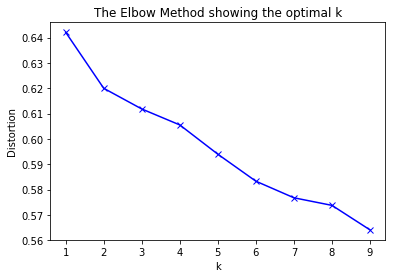

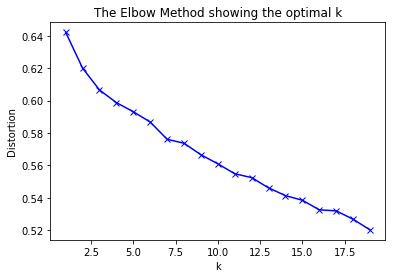

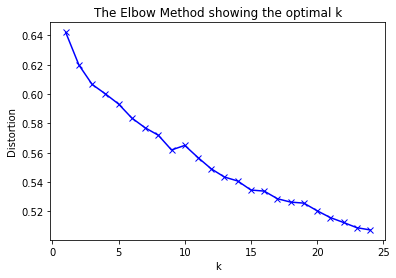

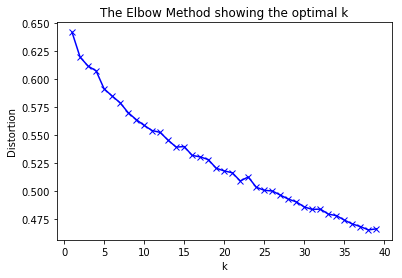

In [490]:
from scipy.spatial.distance import cdist

maximum = [10,20,25,40]
for m in maximum:
    plt.plot()
    distortions = []
    distortions1 = []
    K = range(1,m)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(embd)
        distortions.append(sum(np.min(cdist(embd, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / embd.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

## Elbow Method 2

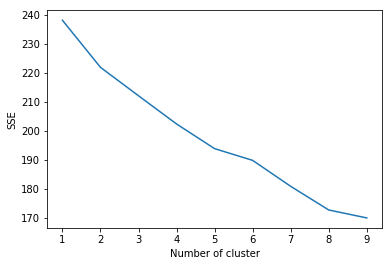

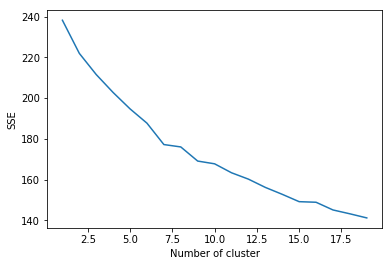

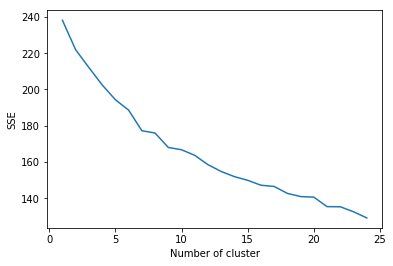

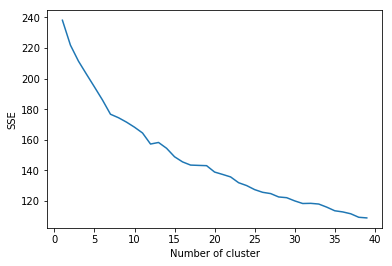

In [491]:
sse = {}

maximum = [10,20,25,40]
for m in maximum:
    plt.plot()
    K = range(1,m)
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(embd)
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()

## Elbow Method 3

In [493]:
cluster_range = range( 1, 25 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters1 = KMeans( num_clusters )
    clusters1.fit(embd)
    cluster_errors.append( clusters1.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:10]

,num_clusters,cluster_errors
0,1,238.172353
1,2,221.906041
2,3,212.138935
3,4,201.952131
4,5,196.961595
5,6,188.577079
6,7,180.081938
7,8,175.558806
8,9,170.015301
9,10,167.920474


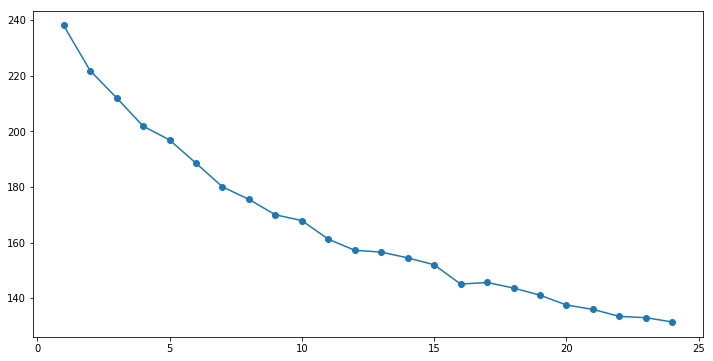

In [494]:
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [501]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(embd)
clusters = kmeans.predict(embd)

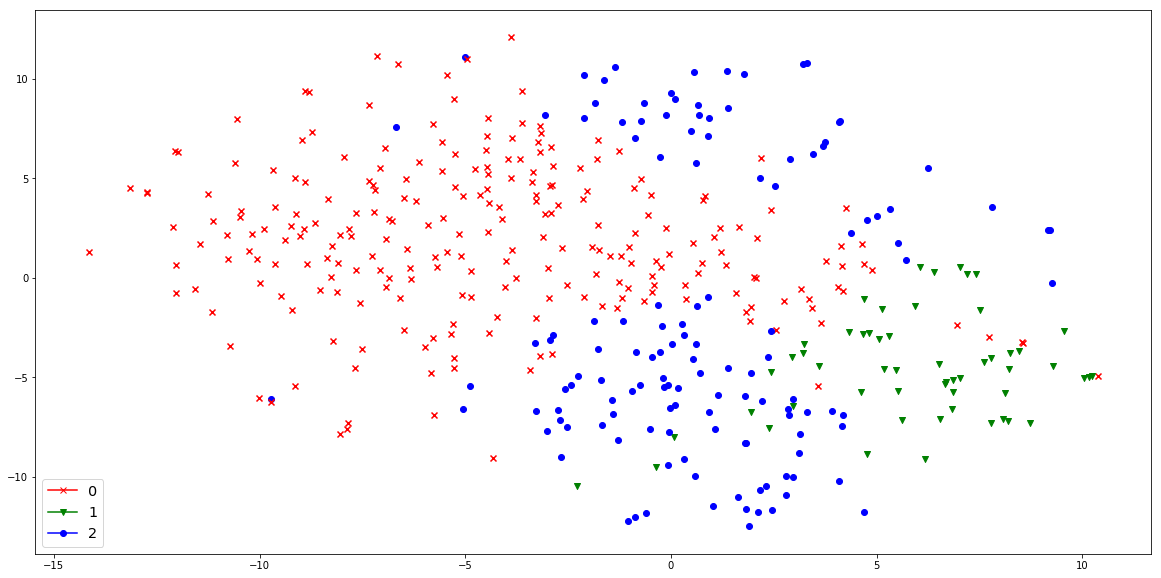

In [502]:
types = ['cl 1', 'cl 2', 'cl 3' , 'cl 4', 'cl 5', 'cl 6', 'cl 7']

markerDict = {0: "x", 1: "v", 2: "o", 3:"s", 4: "p" , 5: ">", 6: "<"}
colorDict = {0: "r", 1: "g", 2: "b", 3:"c", 4: "m" , 5: "y", 6: "k"}

fig, ax = plt.subplots(figsize=(20, 10))
for x,y,c in zip(t[0],t[1],clusters):
    ax.scatter(x, y, c = colorDict[c], marker = markerDict[c])
    
types = []
for c_id in set(clusters):
    types.append(Line2D([0], [0], color=colorDict[c_id], marker=markerDict[c_id], label=c_id))

plt.legend(handles=types, loc='lower left', fontsize='x-large')
plt.show()
